In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()  #

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

In [4]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [5]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [6]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["8b80aa05d88b518b"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [7]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [8]:
left_turn_types = [
    "stopping_at_crosswalk",
    "high_lateral_acceleration",
    "near_multiple_vehicles",
    "on_stopline_stop_sign",
    "near_long_vehicle",
    "unknown",
    "near_barrier_on_driveable",
    "near_high_speed_vehicle",
]
scenario_types = [
    "starting_left_turn",
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

left_turn_potential = [
    "starting_left_turn",
    "starting_unprotected_cross_turn",
]

# scenario_types = ['stationary_at_traffic_light_without_lead']

# selected_scenario_tokens = ["4b95591c786b5558"]  # cross bug
# selected_scenario_tokens = ["2b430abcf49554c7"]  # merge occlusion bug

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    # "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    "scenario_filter.num_scenarios_per_type=400",  # use 10 scenarios per scenario type #bring this back to 25 for testing the cross bug
    # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]

In [9]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=True",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        "+modify_scenario_simulations=true",
        "+modifier_types=[diverge-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=true",
        "+occlusion=true",
        "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion.uncloak_reaction_time=1.5",  # 0.1
        "+occlusion.notice_threshold=1.0",  # 0.1
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')


# closed mixed for simulation
# "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# # "model=gc_pgp_model",
# # "model.aggregator.pre_train=false",
# # "planner.ml_planner.model_config=${model}",
# # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
# # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
# # "+observation.model=gc_pgp_model",
# # "+observation.model.aggregator.pre_train=false",
# # "+observation.model_config=${model}",
# # f"+observation.checkpoint_path={gc_pgp_ckpt}",
# f"observation.planner_type=pdm_closed",
# # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
# f"observation.occlusion_cfg.occlusion=true",
# f"observation.occlusion_cfg.manager_type=wedge",
# f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
# f"+observation.occlusion_cfg.notice_threshold=1.0",
# "+modify_scenario_simulations=true",
# "+modifier_types=[occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right]
# "+occlusion=true",
# "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
# "+occlusion.uncloak_reaction_time=1.0",
# "+occlusion.notice_threshold=0.1",
# "worker=ray_distributed",  # [sequential, ray_distributed]
# "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
# *DATASET_PARAMS,


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,

default_simulation
output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.17.29.21"


# Now we can run with the following

In [10]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-04-05 17:29:21,429 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-05 17:29:21,431 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-05 17:29:23,175	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-05 17:29:23,983 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-05 17:29:23,983 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-04-05 17:29:23,984 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-05 17:29:23,984 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-05 17:29:23,984 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.17.29.21

2024-04-05 17:29:23,987 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


2024-04-05 17:29:46,838 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-05 17:29:47,104 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-05 17:29:47,104 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 697 scenarios...
2024-04-05 17:29:56,015 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
1 0 are the number of cpus and gpus
2024-04-05 17:29:56,015 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:116}  Submitting 697 tasks!


100%|██████████| 3/3 [00:00<00:00, 772.53it/s]
697it [00:00, 23855.19it/s]


[
	'25b0e5c53483588e',
	'3d4e319f81865ff4',
	'5fae6b21738d55b6',
	'758f4fcc4d68573a',
	'b28b1dc4b5ac5522',
	'e72f1ff10a7758b9',
	'efd71b7af2f45f96'
]
2024-04-05 17:33:15,725 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:203}  Created 12 modified scenarios from 697 scenarios, 7 of which were modifiable.
2024-04-05 17:33:15,725 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:204}  Building simulations...DONE!
2024-04-05 17:33:15,729 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation...
2024-04-05 17:33:15,729 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2024-04-05 17:33:15,729 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 12 simulations using RayDistributed!


Ray objects: 100%|██████████| 12/12 [01:12<00:00,  6.04s/it]


2024-04-05 17:34:28,270 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 12
2024-04-05 17:34:28,270 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-04-05 17:34:28,270 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-04-05 17:34:28,290 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.17.29.21/runner_report.parquet
2024-04-05 17:34:28,291 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:05:07 [HH:MM:SS]
2024-04-05 17:34:28,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-04-05 17:34:28,710 

# Now we set up the second running regime

In [11]:
#########################################

path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print(f"+scenarios_to_check_in_alternate_regime={scenario_list}")

hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)
cfg_unocc = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=false",
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+scenarios_to_check_in_alternate_regime={scenario_list}",
        "+modifier_types=[diverge-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=true",
        "+occlusion=false",
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_unocc = cfg_unocc.output_dir
print('output_folder_unocc = "' + output_folder_unocc + '"')

+scenarios_to_check_in_alternate_regime=['efd71b7af2f45f96_diverge_conflict_injection_and_occlusion_injection_149534', 'efd71b7af2f45f96_diverge_conflict_injection_and_occlusion_injection_049534']
output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.17.34.31"


## Run Second Regime

In [12]:
main_simulation(cfg_unocc)

Global seed set to 0


2024-04-05 17:34:31,255 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-04-05 17:34:31,277 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-04-05 17:34:31,441 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-05 17:34:31,442 WARNING {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2024-04-05 17:34:34,899 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-05 17:34:36,704	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-05 17:34:37,510 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-05 17:34:37,511 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-04-05 17:34:37,511 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-05 17:34:37,511 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-05 17:34:37,511 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.17.34.31

2024-04-05 17:34:37,513 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


2024-04-05 17:35:01,071 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-05 17:35:01,198 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-05 17:35:01,198 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 697 scenarios...
2024-04-05 17:35:09,529 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
[
	'efd71b7af2f45f96'
]
2024-04-05 17:35:09,538 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:203}  Created 2 modified scenarios from 697 scenarios, 7 of which were modifiable.
2024-04-05 17:35:09,539 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:204}  Building simulations...DONE!
2024-04-05 17:35:09,543 INFO {/home/

Ray objects: 100%|██████████| 2/2 [00:38<00:00, 19.38s/it]


2024-04-05 17:35:48,304 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 2
2024-04-05 17:35:48,305 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-04-05 17:35:48,305 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-04-05 17:35:48,308 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.17.34.31/runner_report.parquet
2024-04-05 17:35:48,309 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:01:17 [HH:MM:SS]
2024-04-05 17:35:48,389 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-04-05 17:35:48,443 I

number_of_ego_collisions_with_vehicles_stat_value (top 25 differences)
positive diff
                                                                scenario_name  difference                                     scenario_type_1
0  efd71b7af2f45f96_diverge_conflict_injection_and_occlusion_injection_149534           0  starting_straight_stop_sign_intersection_traversal
1  efd71b7af2f45f96_diverge_conflict_injection_and_occlusion_injection_049534           0  starting_straight_stop_sign_intersection_traversal
negative diff
                                                                scenario_name  difference                                     scenario_type_1
0  efd71b7af2f45f96_diverge_conflict_injection_and_occlusion_injection_149534           0  starting_straight_stop_sign_intersection_traversal
1  efd71b7af2f45f96_diverge_conflict_injection_and_occlusion_injection_049534           0  starting_straight_stop_sign_intersection_traversal


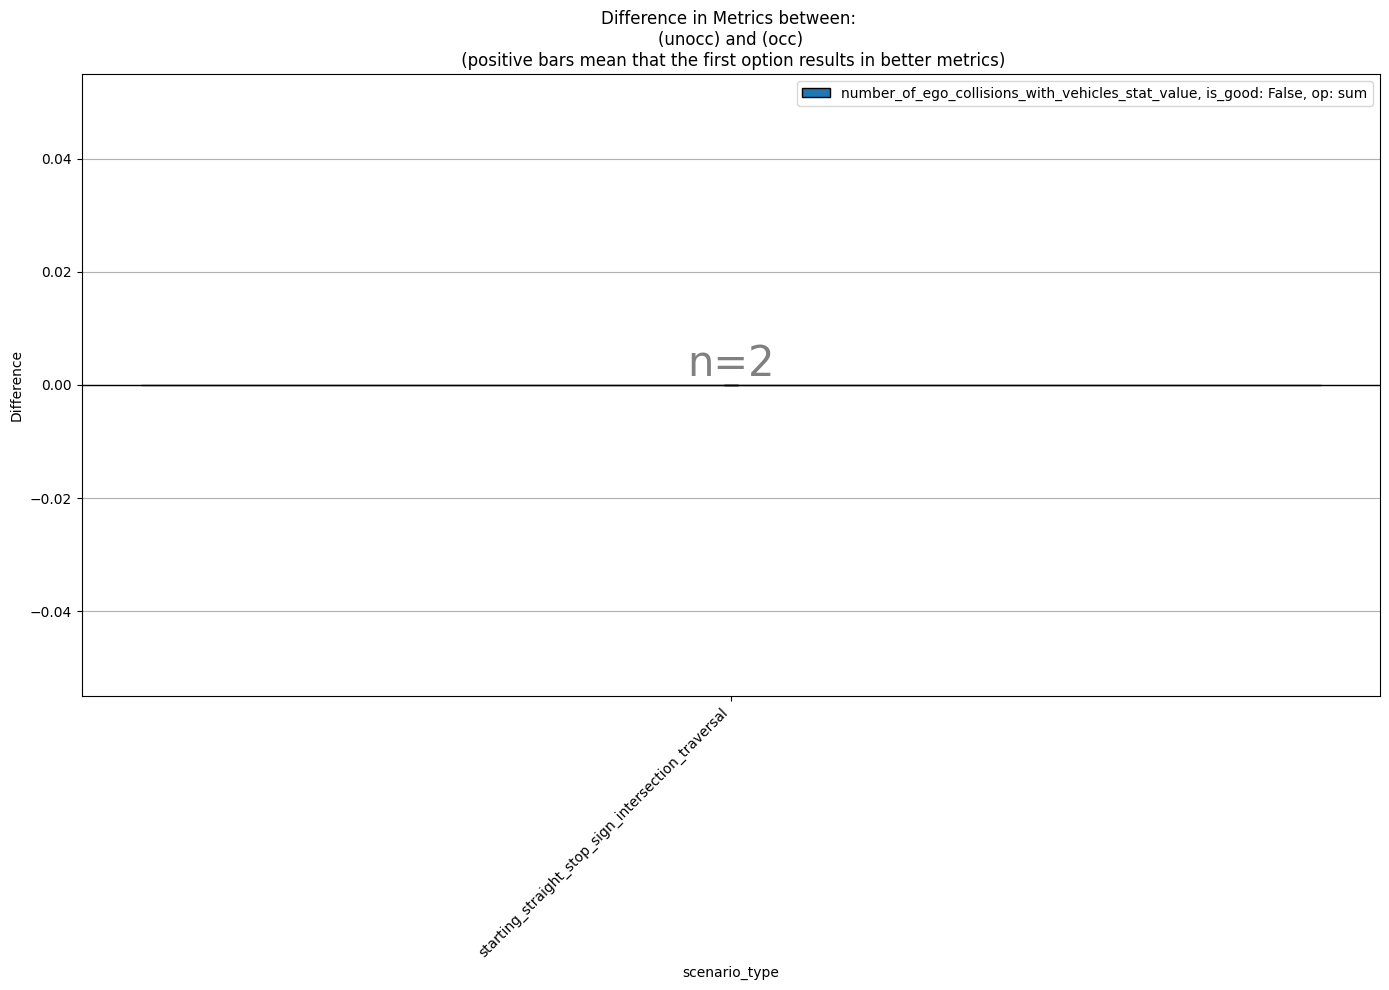

In [13]:
from vis_utils import plot_diff

# %env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
# %env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
# %env NUPLAN_EXP_ROOT=../../data/nuplan/exp
# %env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
# %pwd

file_path_1 = output_folder_unocc + "/metrics/" + "no_ego_at_fault_collisions.parquet"
file_path_2 = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"


metrics = [
    "number_of_ego_collisions_with_vehicles_stat_value",
]
metric_op = [
    "sum",
]
# metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [
    False,
]

plot_diff(
    file_path_1,
    file_path_2,
    "unocc",
    "occ",
    metrics,
    metric_op,
    good_metric,
    group_by="scenario_type",
    k_differences=25,
    as_bool=True,
)

## Prepare the nuBoard config

In [14]:
# import hydra
# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.55.22"
# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.05.19.32.17"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.05.20.12.11"
# )
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.05.09.04"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.05.12.03"

# output_folder_unocc = '../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.00.15.36'
output_folder = [output_folder_occ, output_folder_unocc]
# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.04.32.36"
# )
# output_folder = [output_folder_occ]
print(output_folder_occ)
print(output_folder_unocc)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.17.29.21
../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.17.34.31


## Launch nuBoard (open in new tab - recommended)


In [15]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-04-05 17:35:48,941 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-04-05 17:35:48,959 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-04-05 17:35:48,960 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-04-05 17:35:48,960 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-04-05 17:35:48,960 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-04-05 17:35:48,961 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 373.72ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.58ms


2024-04-05 17:35:50,721 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.58ms
2024-04-05 17:35:50,721 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-04-05 17:35:50,722 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created
2024-04-05 17:35:51,322 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-04-05 17:35:51,331 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0006 seconds.
2024-04-05 17:35:51,427 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 340.59ms


INFO:tornado.access:200 GET / (127.0.0.1) 340.59ms
